In [79]:
pip install pandas numpy matplotlib seaborn jsonpickle statsmodels

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 9.9 MB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 30.3 MB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 232 kB 2.4 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import datetime
import json
import jsonpickle
from collections import defaultdict
from typing import List, Dict, Any
from datamodel import TradingState, Listing, OrderDepth, Trade, Observation, Order
import io
import statsmodels.api as sm
from trader import Trader

In [86]:
class Backtester:
    def __init__(self, trader, listings: Dict[str, Listing], position_limit: Dict[str, int], fair_marks, 
                 market_data: pd.DataFrame, trade_history: pd.DataFrame, file_name: str = None):
        self.trader = trader
        self.listings = listings
        self.market_data = market_data
        self.position_limit = position_limit
        self.fair_marks = fair_marks
        self.trade_history = trade_history.sort_values(by=['timestamp', 'symbol'])
        self.file_name = file_name

        self.observations = [Observation({}, {}) for _ in range(len(market_data))]

        self.current_position = {product: 0 for product in self.listings.keys()}
        self.pnl_history = []
        self.pnl = {product: 0 for product in self.listings.keys()}
        self.cash = {product: 0 for product in self.listings.keys()}
        self.trades = []
        self.sandbox_logs = []
        
    def run(self):
        traderData = ""
        
        timestamp_group_md = self.market_data.groupby('timestamp')
        timestamp_group_th = self.trade_history.groupby('timestamp')
        
        own_trades = defaultdict(list)
        market_trades = defaultdict(list)
        pnl_product = defaultdict(float)
        
        trade_history_dict = {}
        
        for timestamp, group in timestamp_group_th:
            trades = []
            for _, row in group.iterrows():
                symbol = row['symbol']
                price = row['price']
                quantity = row['quantity']
                buyer = row['buyer'] if pd.notnull(row['buyer']) else ""
                seller = row['seller'] if pd.notnull(row['seller']) else ""

                
                trade = Trade(symbol, int(price), int(quantity), buyer, seller, timestamp)
                
                trades.append(trade)
            trade_history_dict[timestamp] = trades
        
        
        for timestamp, group in timestamp_group_md:
            order_depths = self._construct_order_depths(group)
            order_depths_matching = self._construct_order_depths(group)
            order_depths_pnl = self._construct_order_depths(group)
            state = self._construct_trading_state(traderData, timestamp, self.listings, order_depths, 
                                 dict(own_trades), dict(market_trades), self.current_position, self.observations)
            orders, conversions, traderData = self.trader.run(state)
            products = group['product'].tolist()
            sandboxLog = ""
            trades_at_timestamp = trade_history_dict.get(timestamp, [])

            for product in products:
                new_trades = []
                for order in orders.get(product, []):
                    trades_done, sandboxLog = self._execute_order(timestamp, order, order_depths_matching, self.current_position, self.cash, trade_history_dict, sandboxLog)
                    new_trades.extend(trades_done)
                if len(new_trades) > 0:
                    own_trades[product] = new_trades
            self.sandbox_logs.append({"sandboxLog": sandboxLog, "lambdaLog": "", "timestamp": timestamp})

            trades_at_timestamp = trade_history_dict.get(timestamp, [])
            if trades_at_timestamp:
                for trade in trades_at_timestamp:
                    product = trade.symbol
                    market_trades[product].append(trade)
            else: 
                for product in products:
                    market_trades[product] = []

            
            for product in products:
                self._mark_pnl(self.cash, self.current_position, order_depths_pnl, self.pnl, product)
                self.pnl_history.append(self.pnl[product])
            self._add_trades(own_trades, market_trades)
        return self._log_trades(self.file_name)
    
    
    def _log_trades(self, filename: str = None):
        if filename is None:
            return 

        self.market_data['profit_and_loss'] = self.pnl_history

        output = ""
        output += "Sandbox logs:\n"
        for i in self.sandbox_logs:
            output += json.dumps(i, indent=2) + "\n"

        output += "\n\n\n\nActivities log:\n"
        market_data_csv = self.market_data.to_csv(index=False, sep=";")
        market_data_csv = market_data_csv.replace("\r\n", "\n")
        output += market_data_csv

        output += "\n\n\n\nTrade History:\n"
        output += json.dumps(self.trades, indent=2)

        with open(filename, 'w') as file:
            file.write(output)

            
    def _add_trades(self, own_trades: Dict[str, List[Trade]], market_trades: Dict[str, List[Trade]]):
        products = set(own_trades.keys()) | set(market_trades.keys())
        for product in products:
            self.trades.extend([self._trade_to_dict(trade) for trade in own_trades.get(product, [])])
        for product in products:
            self.trades.extend([self._trade_to_dict(trade) for trade in market_trades.get(product, [])])

    def _trade_to_dict(self, trade: Trade) -> dict[str, Any]:
        return {
            "timestamp": trade.timestamp,
            "buyer": trade.buyer,
            "seller": trade.seller,
            "symbol": trade.symbol,
            "currency": "SEASHELLS",
            "price": trade.price,
            "quantity": trade.quantity,
        }
        
    def _construct_trading_state(self, traderData, timestamp, listings, order_depths, 
                                 own_trades, market_trades, position, observations):
        state = TradingState(traderData, timestamp, listings, order_depths, 
                             own_trades, market_trades, position, observations)
        return state
    
        
    def _construct_order_depths(self, group):
        order_depths = {}
        for idx, row in group.iterrows():
            product = row['product']
            order_depth = OrderDepth()
            for i in range(1, 4):
                if f'bid_price_{i}' in row and f'bid_volume_{i}' in row:
                    bid_price = row[f'bid_price_{i}']
                    bid_volume = row[f'bid_volume_{i}']
                    if not pd.isna(bid_price) and not pd.isna(bid_volume):
                        order_depth.buy_orders[int(bid_price)] = int(bid_volume)
                if f'ask_price_{i}' in row and f'ask_volume_{i}' in row:
                    ask_price = row[f'ask_price_{i}']
                    ask_volume = row[f'ask_volume_{i}']
                    if not pd.isna(ask_price) and not pd.isna(ask_volume):
                        order_depth.sell_orders[int(ask_price)] = -int(ask_volume)
            order_depths[product] = order_depth
        return order_depths
    
        
        
    def _execute_buy_order(self, timestamp, order, order_depths, position, cash, trade_history_dict, sandboxLog):
        trades = []
        order_depth = order_depths[order.symbol]

        for price, volume in list(order_depth.sell_orders.items()):
            if price > order.price or order.quantity == 0:
                break

            trade_volume = min(abs(order.quantity), abs(volume))
            if abs(trade_volume + position[order.symbol]) <= int(self.position_limit[order.symbol]):
                trades.append(Trade(order.symbol, price, trade_volume, "SUBMISSION", "", timestamp))
                position[order.symbol] += trade_volume
                self.cash[order.symbol] -= price * trade_volume
                order_depth.sell_orders[price] += trade_volume
                order.quantity -= trade_volume
            else:
                sandboxLog += f"\nOrders for product {order.symbol} exceeded limit of {self.position_limit[order.symbol]} set"
            

            if order_depth.sell_orders[price] == 0:
                del order_depth.sell_orders[price]
        
        trades_at_timestamp = trade_history_dict.get(timestamp, [])
        new_trades_at_timestamp = []
        for trade in trades_at_timestamp:
            if trade.symbol == order.symbol:
                if trade.price < order.price:
                    trade_volume = min(abs(order.quantity), abs(trade.quantity))
                    trades.append(Trade(order.symbol, order.price, trade_volume, "SUBMISSION", "", timestamp))
                    order.quantity -= trade_volume
                    position[order.symbol] += trade_volume
                    self.cash[order.symbol] -= order.price * trade_volume
                    if trade_volume == abs(trade.quantity):
                        continue
                    else:
                        new_quantity = trade.quantity - trade_volume
                        new_trades_at_timestamp.append(Trade(order.symbol, order.price, new_quantity, "", "", timestamp))
                        continue
            new_trades_at_timestamp.append(trade)  

        if len(new_trades_at_timestamp) > 0:
            trade_history_dict[timestamp] = new_trades_at_timestamp

        return trades, sandboxLog
        
        
        
    def _execute_sell_order(self, timestamp, order, order_depths, position, cash, trade_history_dict, sandboxLog):
        trades = []
        order_depth = order_depths[order.symbol]
        
        for price, volume in sorted(order_depth.buy_orders.items(), reverse=True):
            if price < order.price or order.quantity == 0:
                break

            trade_volume = min(abs(order.quantity), abs(volume))
            if abs(position[order.symbol] - trade_volume) <= int(self.position_limit[order.symbol]):
                trades.append(Trade(order.symbol, price, trade_volume, "", "SUBMISSION", timestamp))
                position[order.symbol] -= trade_volume
                self.cash[order.symbol] += price * abs(trade_volume)
                order_depth.buy_orders[price] -= abs(trade_volume)
                order.quantity += trade_volume
            else:
                sandboxLog += f"\nOrders for product {order.symbol} exceeded limit of {self.position_limit[order.symbol]} set"

            if order_depth.buy_orders[price] == 0:
                del order_depth.buy_orders[price]

        trades_at_timestamp = trade_history_dict.get(timestamp, [])
        new_trades_at_timestamp = []
        for trade in trades_at_timestamp:
            if trade.symbol == order.symbol:
                if trade.price > order.price:
                    trade_volume = min(abs(order.quantity), abs(trade.quantity))
                    trades.append(Trade(order.symbol, order.price, trade_volume, "", "SUBMISSION", timestamp))
                    order.quantity += trade_volume
                    position[order.symbol] -= trade_volume
                    self.cash[order.symbol] += order.price * trade_volume
                    if trade_volume == abs(trade.quantity):
                        continue
                    else:
                        new_quantity = trade.quantity - trade_volume
                        new_trades_at_timestamp.append(Trade(order.symbol, order.price, new_quantity, "", "", timestamp))
                        continue
            new_trades_at_timestamp.append(trade)  

        if len(new_trades_at_timestamp) > 0:
            trade_history_dict[timestamp] = new_trades_at_timestamp
                
        return trades, sandboxLog
        
        
        
    def _execute_order(self, timestamp, order, order_depths, position, cash, trades_at_timestamp, sandboxLog):
        if order.quantity == 0:
            return []
        
        order_depth = order_depths[order.symbol]
        if order.quantity > 0:
            return self._execute_buy_order(timestamp, order, order_depths, position, cash, trades_at_timestamp, sandboxLog)
        else:
            return self._execute_sell_order(timestamp, order, order_depths, position, cash, trades_at_timestamp, sandboxLog)
    
    def _mark_pnl(self, cash, position, order_depths, pnl, product):
        order_depth = order_depths[product]
        
        best_ask = min(order_depth.sell_orders.keys())
        best_bid = max(order_depth.buy_orders.keys())
        mid = (best_ask + best_bid)/2
        fair = mid
        if product in self.fair_marks:
            get_fair = self.fair_marks[product]
            fair = get_fair(order_depth)
        
        pnl[product] = cash[product] + fair * position[product]
        

In [96]:
class Product:
    RAINFOREST_RESIN = "RAINFOREST_RESIN"
    KELP = "KELP"

# Define parameters for each product, including fair value estimation and trading strategy settings
PARAMS = {
    Product.RAINFOREST_RESIN: {
        "fair_value": 10000,  # Estimated fair price for trading decisions
        "take_width": 1,  # Price width within which we aggressively take orders
        "clear_width": 0,  # Threshold for clearing orders
        "disregard_edge": 1,  # Ignore orders too close to fair value
        "join_edge": 2,  # Join existing orders within this range
        "default_edge": 2,  # Default spread if no other condition applies
        "soft_position_limit": 12,  # Soft limit on how many units we hold before adjusting strategy
    },
    Product.KELP: {
        "take_width": 1,
        "clear_width": 0,
        "prevent_adverse": True,  # Avoid large trades that could move the market against us
        "adverse_volume": 15,  # Maximum volume to avoid for adverse selection
        "reversion_beta": 0.2145,  # Mean reversion parameter
        "disregard_edge": 1,
        "join_edge": 0,
        "default_edge": 1,
    },
}


class Trader:
    def __init__(self, params=None):
        if params is None:
            params = PARAMS
        self.params = params

        # Define position limits for each product
        self.LIMIT = {Product.RAINFOREST_RESIN: 50, Product.KELP: 50}

    def take_best_orders(
        self,
        product: str,
        fair_value: int,
        take_width: float,
        orders: List[Order],
        order_depth: OrderDepth,
        position: int,
        buy_order_volume: int,
        sell_order_volume: int,
        prevent_adverse: bool = False,
        adverse_volume: int = 0,
    ) -> (int, int):
        """
        Executes aggressive trades by taking the best available market orders within a given threshold.
        :param product: The product being traded
        :param fair_value: Estimated fair value of the asset
        :param take_width: Price width within which to take orders
        :param orders: List of orders to be placed
        :param order_depth: Current market order book
        :param position: Current position held
        :param buy_order_volume: Volume of buy orders already placed
        :param sell_order_volume: Volume of sell orders already placed
        :param prevent_adverse: Flag to prevent taking large adverse trades
        :param adverse_volume: Max volume allowed to avoid adverse selection
        :return: Updated buy and sell order volumes
        """
        position_limit = self.LIMIT[product]

        # Check if there are sell orders available to buy from
        if len(order_depth.sell_orders) != 0:
            best_ask = min(order_depth.sell_orders.keys())  # Lowest selling price
            best_ask_amount = -1 * order_depth.sell_orders[best_ask]  # Available volume to buy

            # Avoid taking orders that are too large (adverse selection prevention)
            if not prevent_adverse or abs(best_ask_amount) <= adverse_volume:
                if best_ask <= fair_value - take_width:
                    quantity = min(best_ask_amount, position_limit - position)  # Max buyable amount
                    if quantity > 0:
                        orders.append(Order(product, best_ask, quantity))
                        buy_order_volume += quantity
                        order_depth.sell_orders[best_ask] += quantity
                        if order_depth.sell_orders[best_ask] == 0:
                            del order_depth.sell_orders[best_ask]

        # Check if there are buy orders available to sell to
        if len(order_depth.buy_orders) != 0:
            best_bid = max(order_depth.buy_orders.keys())  # Highest buying price
            best_bid_amount = order_depth.buy_orders[best_bid]  # Available volume to sell

            if not prevent_adverse or abs(best_bid_amount) <= adverse_volume:
                if best_bid >= fair_value + take_width:
                    quantity = min(best_bid_amount, position_limit + position)  # Max sellable amount
                    if quantity > 0:
                        orders.append(Order(product, best_bid, -1 * quantity))
                        sell_order_volume += quantity
                        order_depth.buy_orders[best_bid] -= quantity
                        if order_depth.buy_orders[best_bid] == 0:
                            del order_depth.buy_orders[best_bid]

        return buy_order_volume, sell_order_volume

    def market_make(
        self,
        product: str,
        orders: List[Order],
        bid: int,
        ask: int,
        position: int,
        buy_order_volume: int,
        sell_order_volume: int,
    ) -> (int, int):
        """
        Places limit orders to make the market by providing liquidity at bid and ask prices.
        :param product: The product being traded
        :param orders: List of orders to be placed
        :param bid: Price at which we are willing to buy
        :param ask: Price at which we are willing to sell
        :param position: Current position held
        :param buy_order_volume: Volume of buy orders already placed
        :param sell_order_volume: Volume of sell orders already placed
        :return: Updated buy and sell order volumes
        """
        # Determine how much we can still buy within the position limit
        buy_quantity = self.LIMIT[product] - (position + buy_order_volume)
        if buy_quantity > 0:
            orders.append(Order(product, round(bid), buy_quantity))  # Place buy order

        # Determine how much we can still sell within the position limit
        sell_quantity = self.LIMIT[product] + (position - sell_order_volume)
        if sell_quantity > 0:
            orders.append(Order(product, round(ask), -sell_quantity))  # Place sell order

        return buy_order_volume, sell_order_volume
    
    def clear_position_order(
        self,
        product: str,
        fair_value: float,
        width: int,
        orders: List[Order],
        order_depth: OrderDepth,
        position: int,
        buy_order_volume: int,
        sell_order_volume: int,
    ) -> List[Order]:
        """
        Clears existing positions by placing orders at a fair price with a given width.
        
        - If the trader has a net positive position, it places sell orders at a fair price + width.
        - If the trader has a net negative position, it places buy orders at a fair price - width.
        """
        position_after_take = position + buy_order_volume - sell_order_volume
        fair_for_bid = round(fair_value - width)
        fair_for_ask = round(fair_value + width)

        buy_quantity = self.LIMIT[product] - (position + buy_order_volume)
        sell_quantity = self.LIMIT[product] + (position - sell_order_volume)

        if position_after_take > 0:
            # Determine total volume from all buy orders with price greater than fair_for_ask
            clear_quantity = sum(
                volume
                for price, volume in order_depth.buy_orders.items()
                if price >= fair_for_ask
            )
            clear_quantity = min(clear_quantity, position_after_take)
            sent_quantity = min(sell_quantity, clear_quantity)
            if sent_quantity > 0:
                orders.append(Order(product, fair_for_ask, -abs(sent_quantity)))
                sell_order_volume += abs(sent_quantity)

        if position_after_take < 0:
            # Determine total volume from all sell orders with price lower than fair_for_bid
            clear_quantity = sum(
                abs(volume)
                for price, volume in order_depth.sell_orders.items()
                if price <= fair_for_bid
            )
            clear_quantity = min(clear_quantity, abs(position_after_take))
            sent_quantity = min(buy_quantity, clear_quantity)
            if sent_quantity > 0:
                orders.append(Order(product, fair_for_bid, abs(sent_quantity)))
                buy_order_volume += abs(sent_quantity)

        return buy_order_volume, sell_order_volume

    def kelp_fair_value(self, order_depth: OrderDepth, traderObject) -> float:
        """
        Computes the fair value of KELP using market mid-prices and a mean-reversion model.
        
        - If the order book is non-empty, it calculates the mid-price.
        - Adjusts the fair price based on a reversion model if historical data is available.
        """
        if len(order_depth.sell_orders) != 0 and len(order_depth.buy_orders) != 0:
            best_ask = min(order_depth.sell_orders.keys())
            best_bid = max(order_depth.buy_orders.keys())
            
            # Filter orders that exceed the adverse volume threshold
            filtered_ask = [
                price
                for price in order_depth.sell_orders.keys()
                if abs(order_depth.sell_orders[price])
                >= self.params[Product.KELP]["adverse_volume"]
            ]
            filtered_bid = [
                price
                for price in order_depth.buy_orders.keys()
                if abs(order_depth.buy_orders[price])
                >= self.params[Product.KELP]["adverse_volume"]
            ]
            
            mm_ask = min(filtered_ask) if len(filtered_ask) > 0 else None
            mm_bid = max(filtered_bid) if len(filtered_bid) > 0 else None
            
            # If no valid mid-market price, use last stored price or default to midpoint
            if mm_ask == None or mm_bid == None:
                if traderObject.get("kelp_last_price", None) == None:
                    mmmid_price = (best_ask + best_bid) / 2
                else:
                    mmmid_price = traderObject["kelp_last_price"]
            else:
                mmmid_price = (mm_ask + mm_bid) / 2

            # Apply mean-reversion adjustment if last price is known
            if traderObject.get("kelp_last_price", None) != None:
                last_price = traderObject["kelp_last_price"]
                last_returns = (mmmid_price - last_price) / last_price
                pred_returns = (
                    last_returns * self.params[Product.KELP]["reversion_beta"]
                )
                fair = mmmid_price + (mmmid_price * pred_returns)
            else:
                fair = mmmid_price
            
            # Store the last computed price
            traderObject["kelp_last_price"] = mmmid_price
            return fair
        return None

    def take_orders(
        self,
        product: str,
        order_depth: OrderDepth,
        fair_value: float,
        take_width: float,
        position: int,
        prevent_adverse: bool = False,
        adverse_volume: int = 0,
    ) -> (List[Order], int, int):
        """
        Places market orders to take the best available prices within a given width.
        
        - Avoids adverse selection if enabled.
        - Takes into account position limits.
        """
        orders: List[Order] = []
        buy_order_volume = 0
        sell_order_volume = 0

        buy_order_volume, sell_order_volume = self.take_best_orders(
            product,
            fair_value,
            take_width,
            orders,
            order_depth,
            position,
            buy_order_volume,
            sell_order_volume,
            prevent_adverse,
            adverse_volume,
        )
        return orders, buy_order_volume, sell_order_volume

    def clear_orders(
        self,
        product: str,
        order_depth: OrderDepth,
        fair_value: float,
        clear_width: int,
        position: int,
        buy_order_volume: int,
        sell_order_volume: int,
    ) -> (List[Order], int, int):
        """
        Places orders to clear existing positions at a fair price within a given width.
        
        - Ensures that the trader does not hold excessive inventory.
        - Helps maintain liquidity by adjusting to market conditions.
        """
        orders: List[Order] = []
        buy_order_volume, sell_order_volume = self.clear_position_order(
            product,
            fair_value,
            clear_width,
            orders,
            order_depth,
            position,
            buy_order_volume,
            sell_order_volume,
        )
        return orders, buy_order_volume, sell_order_volume
    
    def make_orders(
        self,
        product,
        order_depth: OrderDepth,
        fair_value: float,
        position: int,
        buy_order_volume: int,
        sell_order_volume: int,
        disregard_edge: float,  # Ignore trades within this edge for pennying or joining
        join_edge: float,  # Join trades within this edge
        default_edge: float,  # Default edge to request if there are no levels to penny or join
        manage_position: bool = False,  # Whether to adjust bids/asks based on position
        soft_position_limit: int = 0,  # Threshold to modify orders based on position
    ):
        orders: List[Order] = []
        
        # Identify ask prices above the fair value, considering the disregard edge
        asks_above_fair = [
            price
            for price in order_depth.sell_orders.keys()
            if price > fair_value + disregard_edge
        ]
        
        # Identify bid prices below the fair value, considering the disregard edge
        bids_below_fair = [
            price
            for price in order_depth.buy_orders.keys()
            if price < fair_value - disregard_edge
        ]
        
        # Determine the best ask and best bid beyond the fair value range
        best_ask_above_fair = min(asks_above_fair) if len(asks_above_fair) > 0 else None
        best_bid_below_fair = max(bids_below_fair) if len(bids_below_fair) > 0 else None
        
        # Set default bid and ask prices based on fair value and default edge
        ask = round(fair_value + default_edge)
        bid = round(fair_value - default_edge)
        
        # Adjust ask price if there's an order close enough to fair value
        if best_ask_above_fair is not None:
            if abs(best_ask_above_fair - fair_value) <= join_edge:
                ask = best_ask_above_fair  # Join the existing order
            else:
                ask = best_ask_above_fair - 1  # Undercut by a small amount (pennying)
        
        # Adjust bid price if there's an order close enough to fair value
        if best_bid_below_fair is not None:
            if abs(fair_value - best_bid_below_fair) <= join_edge:
                bid = best_bid_below_fair  # Join the existing order
            else:
                bid = best_bid_below_fair + 1  # Outbid slightly
        
        # Modify orders if position management is enabled
        if manage_position:
            if position > soft_position_limit:
                ask -= 1  # Reduce ask price to sell faster
            elif position < -1 * soft_position_limit:
                bid += 1  # Increase bid price to buy faster
        
        # Execute market making strategy
        buy_order_volume, sell_order_volume = self.market_make(
            product,
            orders,
            bid,
            ask,
            position,
            buy_order_volume,
            sell_order_volume,
        )
        
        return orders, buy_order_volume, sell_order_volume
    
    def run(self, state: TradingState):
        traderObject = {}
        if state.traderData is not None and state.traderData != "":
            traderObject = jsonpickle.decode(state.traderData)
        
        result = {}
        
        # Process trading for RAINFOREST_RESIN
        if Product.RAINFOREST_RESIN in self.params and Product.RAINFOREST_RESIN in state.order_depths:
            resin_position = (
                state.position[Product.RAINFOREST_RESIN]
                if Product.RAINFOREST_RESIN in state.position
                else 0
            )
            # Execute take, clear, and make orders for RAINFOREST_RESIN
            resin_take_orders, buy_order_volume, sell_order_volume = (
                self.take_orders(
                    Product.RAINFOREST_RESIN,
                    state.order_depths[Product.RAINFOREST_RESIN],
                    self.params[Product.RAINFOREST_RESIN]["fair_value"],
                    self.params[Product.RAINFOREST_RESIN]["take_width"],
                    resin_position,
                )
            )
            resin_clear_orders, buy_order_volume, sell_order_volume = (
                self.clear_orders(
                    Product.RAINFOREST_RESIN,
                    state.order_depths[Product.RAINFOREST_RESIN],
                    self.params[Product.RAINFOREST_RESIN]["fair_value"],
                    self.params[Product.RAINFOREST_RESIN]["clear_width"],
                    resin_position,
                    buy_order_volume,
                    sell_order_volume,
                )
            )
            resin_make_orders, _, _ = self.make_orders(
                Product.RAINFOREST_RESIN,
                state.order_depths[Product.RAINFOREST_RESIN],
                self.params[Product.RAINFOREST_RESIN]["fair_value"],
                resin_position,
                buy_order_volume,
                sell_order_volume,
                self.params[Product.RAINFOREST_RESIN]["disregard_edge"],
                self.params[Product.RAINFOREST_RESIN]["join_edge"],
                self.params[Product.RAINFOREST_RESIN]["default_edge"],
                True,
                self.params[Product.RAINFOREST_RESIN]["soft_position_limit"],
            )
            result[Product.RAINFOREST_RESIN] = (
                resin_take_orders + resin_clear_orders + resin_make_orders
            )
        
        # Process trading for KELP
        if Product.KELP in self.params and Product.KELP in state.order_depths:
            kelp_position = (
                state.position[Product.KELP]
                if Product.KELP in state.position
                else 0
            )
            kelp_fair_value = self.kelp_fair_value(
                state.order_depths[Product.KELP], traderObject
            )
            kelp_take_orders, buy_order_volume, sell_order_volume = (
                self.take_orders(
                    Product.KELP,
                    state.order_depths[Product.KELP],
                    kelp_fair_value,
                    self.params[Product.KELP]["take_width"],
                    kelp_position,
                    self.params[Product.KELP]["prevent_adverse"],
                    self.params[Product.KELP]["adverse_volume"],
                )
            )
            kelp_clear_orders, buy_order_volume, sell_order_volume = (
                self.clear_orders(
                    Product.KELP,
                    state.order_depths[Product.KELP],
                    kelp_fair_value,
                    self.params[Product.KELP]["clear_width"],
                    kelp_position,
                    buy_order_volume,
                    sell_order_volume,
                )
            )
            kelp_make_orders, _, _ = self.make_orders(
                Product.KELP,
                state.order_depths[Product.KELP],
                kelp_fair_value,
                kelp_position,
                buy_order_volume,
                sell_order_volume,
                self.params[Product.KELP]["disregard_edge"],
                self.params[Product.KELP]["join_edge"],
                self.params[Product.KELP]["default_edge"],
            )
            result[Product.KELP] = (
                kelp_take_orders + kelp_clear_orders + kelp_make_orders
            )
        
        conversions = 1
        traderData = jsonpickle.encode(traderObject)
        
        return result, conversions, traderData

In [97]:
def _process_data_(file):
    with open(file, 'r') as file:
        log_content = file.read()
    sections = log_content.split('Sandbox logs:')[1].split('Activities log:')
    sandbox_log =  sections[0].strip()
    activities_log = sections[1].split('Trade History:')[0]
    # sandbox_log_list = [json.loads(line) for line in sandbox_log.split('\n')]
    trade_history =  json.loads(sections[1].split('Trade History:')[1])
    # sandbox_log_df = pd.DataFrame(sandbox_log_list)
    market_data_df = pd.read_csv(io.StringIO(activities_log), sep=";", header=0)
    trade_history_df = pd.json_normalize(trade_history)
    return market_data_df, trade_history_df

In [98]:
def calculate_kelp_fair(order_depth):
    # assumes order_depth has orders in it 
    best_ask = min(order_depth.sell_orders.keys())
    best_bid = max(order_depth.buy_orders.keys())
    filtered_ask = [price for price in order_depth.sell_orders.keys() if abs(order_depth.sell_orders[price]) >= 15]
    filtered_bid = [price for price in order_depth.buy_orders.keys() if abs(order_depth.buy_orders[price]) >= 15]
    mm_ask = min(filtered_ask) if len(filtered_ask) > 0 else best_ask
    mm_bid = max(filtered_bid) if len(filtered_bid) > 0 else best_bid

    mmmid_price = (mm_ask + mm_bid) / 2
    return mmmid_price
    
def calculate_resin_fair(order_depth):
    return 10000

In [99]:
listings = {
    'RAINFOREST_RESIN': Listing(symbol='RAINFOREST_RESIN', product='RAINFOREST_RESIN', denomination='SEASHELLS'),
    'KELP': Listing(symbol='KELP', product='KELP', denomination='SEASHELLS')
}

position_limit = {
    'RAINFOREST_RESIN': 50,
    'KELP': 50
}

fair_calculations = {
    "RAINFOREST_RESIN": calculate_resin_fair,
    "KELP": calculate_kelp_fair
}

In [100]:
# with fair prediction
market_data = pd.read_csv('data/prices_round0.csv', sep=";", header=0)
trade_history = pd.read_csv('data/trades_round0.csv', sep=";", header=0)

trader = Trader()
backtester = Backtester(trader, listings, position_limit, fair_calculations, market_data, trade_history, file_name="data/backtest_results.txt")
backtester.run()
print(backtester.pnl)

{'RAINFOREST_RESIN': 3232, 'KELP': 711.0}


In [66]:
import itertools

def generate_param_combinations(param_grid):
    param_names = param_grid.keys()
    param_values = param_grid.values()
    combinations = list(itertools.product(*param_values))
    return [dict(zip(param_names, combination)) for combination in combinations]

In [68]:
pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 78 kB 9.9 MB/s eta 0:00:011
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [69]:
import os
from tqdm import tqdm

def run_backtests(trader, listings, position_limit, fair_calcs, market_data, trade_history, backtest_dir, param_grid, symbol):
    if not os.path.exists(backtest_dir):
        os.makedirs(backtest_dir)

    param_combinations = generate_param_combinations(param_grid[symbol])

    results = []
    for params in tqdm(param_combinations, desc=f"Running backtests for {symbol}", unit="backtest"):
        trader.params = {symbol: params}
        backtester = Backtester(trader, listings, position_limit, fair_calcs, market_data, trade_history)
        backtester.run()

        param_str = "-".join([f"{key}={value}" for key, value in params.items()])
        log_filename = f"{backtest_dir}/{symbol}_{param_str}.log"
        backtester._log_trades(log_filename)

        results.append((params, backtester.pnl[symbol]))

    return results

In [72]:
backtest_dir = "backtest_test_clear_width"

param_grid = {
    Product.RAINFOREST_RESIN: {
        "fair_value": [10000],
        "take_width": [1, 2],
        "clear_width": [0, 0.5],
        "volume_limit": [0],
        # for making
        "disregard_edge": [1],  # disregards orders for joining or pennying within this value from fair
        "join_edge": [2],# joins orders within this edge 
        "default_edge": [2, 3, 4],
        "soft_position_limit": [10, 12],
    },
    Product.KELP: {
        "take_width": [1],
        "clear_width": [0, -0.25],
        "prevent_adverse": [True],
        "adverse_volume": [15, 16, 17, 18, 19, 20],
        "reversion_beta": [-0.229],
        # for making
        "disregard_edge": [1],
        "join_edge": [2, 3],
        "default_edge": [4, 5],
    },
}


trader = Trader()

resin_results = run_backtests(trader, listings, position_limit, fair_calculations, market_data, trade_history, backtest_dir, param_grid, "RAINFOREST_RESIN")
print("RAINFOREST_RESIN results:")
for params, pnl in resin_results: 
    print(params)
    print(f"pnl: {pnl}")
    print("="*80)

kelp_results = run_backtests(trader, listings, position_limit, fair_calculations, market_data, trade_history, backtest_dir, param_grid, "KELP")
print("KELP results:")
for params, pnl in kelp_results: 
    print(params)
    print(f"pnl: {pnl}")
    print("="*80)

Running backtests for RAINFOREST_RESIN: 100%|██████████| 24/24 [00:18<00:00,  1.31backtest/s]


RAINFOREST_RESIN results:
{'fair_value': 10000, 'take_width': 1, 'clear_width': 0, 'volume_limit': 0, 'disregard_edge': 1, 'join_edge': 2, 'default_edge': 2, 'soft_position_limit': 10}
pnl: 3196
{'fair_value': 10000, 'take_width': 1, 'clear_width': 0, 'volume_limit': 0, 'disregard_edge': 1, 'join_edge': 2, 'default_edge': 2, 'soft_position_limit': 12}
pnl: 3232
{'fair_value': 10000, 'take_width': 1, 'clear_width': 0, 'volume_limit': 0, 'disregard_edge': 1, 'join_edge': 2, 'default_edge': 3, 'soft_position_limit': 10}
pnl: 3196
{'fair_value': 10000, 'take_width': 1, 'clear_width': 0, 'volume_limit': 0, 'disregard_edge': 1, 'join_edge': 2, 'default_edge': 3, 'soft_position_limit': 12}
pnl: 3232
{'fair_value': 10000, 'take_width': 1, 'clear_width': 0, 'volume_limit': 0, 'disregard_edge': 1, 'join_edge': 2, 'default_edge': 4, 'soft_position_limit': 10}
pnl: 3196
{'fair_value': 10000, 'take_width': 1, 'clear_width': 0, 'volume_limit': 0, 'disregard_edge': 1, 'join_edge': 2, 'default_edge': 

Running backtests for KELP: 100%|██████████| 48/48 [00:36<00:00,  1.30backtest/s]

KELP results:
{'take_width': 1, 'clear_width': 0, 'prevent_adverse': True, 'adverse_volume': 15, 'reversion_beta': -0.229, 'disregard_edge': 1, 'join_edge': 2, 'default_edge': 4}
pnl: 237.0
{'take_width': 1, 'clear_width': 0, 'prevent_adverse': True, 'adverse_volume': 15, 'reversion_beta': -0.229, 'disregard_edge': 1, 'join_edge': 2, 'default_edge': 5}
pnl: 237.0
{'take_width': 1, 'clear_width': 0, 'prevent_adverse': True, 'adverse_volume': 15, 'reversion_beta': -0.229, 'disregard_edge': 1, 'join_edge': 3, 'default_edge': 4}
pnl: 185.0
{'take_width': 1, 'clear_width': 0, 'prevent_adverse': True, 'adverse_volume': 15, 'reversion_beta': -0.229, 'disregard_edge': 1, 'join_edge': 3, 'default_edge': 5}
pnl: 185.0
{'take_width': 1, 'clear_width': 0, 'prevent_adverse': True, 'adverse_volume': 16, 'reversion_beta': -0.229, 'disregard_edge': 1, 'join_edge': 2, 'default_edge': 4}
pnl: 237.0
{'take_width': 1, 'clear_width': 0, 'prevent_adverse': True, 'adverse_volume': 16, 'reversion_beta': -0.22

In [74]:
sorted_kelp_results = sorted(kelp_results, key=lambda x: x[1], reverse=True)
sorted_kelp_results[0:100]

[({'take_width': 1,
   'clear_width': 0,
   'prevent_adverse': True,
   'adverse_volume': 15,
   'reversion_beta': -0.229,
   'disregard_edge': 1,
   'join_edge': 2,
   'default_edge': 4},
  237.0),
 ({'take_width': 1,
   'clear_width': 0,
   'prevent_adverse': True,
   'adverse_volume': 15,
   'reversion_beta': -0.229,
   'disregard_edge': 1,
   'join_edge': 2,
   'default_edge': 5},
  237.0),
 ({'take_width': 1,
   'clear_width': 0,
   'prevent_adverse': True,
   'adverse_volume': 16,
   'reversion_beta': -0.229,
   'disregard_edge': 1,
   'join_edge': 2,
   'default_edge': 4},
  237.0),
 ({'take_width': 1,
   'clear_width': 0,
   'prevent_adverse': True,
   'adverse_volume': 16,
   'reversion_beta': -0.229,
   'disregard_edge': 1,
   'join_edge': 2,
   'default_edge': 5},
  237.0),
 ({'take_width': 1,
   'clear_width': 0,
   'prevent_adverse': True,
   'adverse_volume': 17,
   'reversion_beta': -0.229,
   'disregard_edge': 1,
   'join_edge': 2,
   'default_edge': 4},
  237.0),
 ({'t

In [75]:
sorted_resin_results = sorted(resin_results, key=lambda x: x[1], reverse=True)
sorted_resin_results[0:100]

[({'fair_value': 10000,
   'take_width': 1,
   'clear_width': 0,
   'volume_limit': 0,
   'disregard_edge': 1,
   'join_edge': 2,
   'default_edge': 2,
   'soft_position_limit': 12},
  3232),
 ({'fair_value': 10000,
   'take_width': 1,
   'clear_width': 0,
   'volume_limit': 0,
   'disregard_edge': 1,
   'join_edge': 2,
   'default_edge': 3,
   'soft_position_limit': 12},
  3232),
 ({'fair_value': 10000,
   'take_width': 1,
   'clear_width': 0,
   'volume_limit': 0,
   'disregard_edge': 1,
   'join_edge': 2,
   'default_edge': 4,
   'soft_position_limit': 12},
  3232),
 ({'fair_value': 10000,
   'take_width': 1,
   'clear_width': 0.5,
   'volume_limit': 0,
   'disregard_edge': 1,
   'join_edge': 2,
   'default_edge': 2,
   'soft_position_limit': 12},
  3232),
 ({'fair_value': 10000,
   'take_width': 1,
   'clear_width': 0.5,
   'volume_limit': 0,
   'disregard_edge': 1,
   'join_edge': 2,
   'default_edge': 3,
   'soft_position_limit': 12},
  3232),
 ({'fair_value': 10000,
   'take_wid

# Load Prices


In [3]:
path = "data/round_1"


def get_prices(round: int, day: int):

    path = f"data/round_{round}/prices_round_{round}_day_{day}.csv"

    return pd.read_csv(path, sep=";")


def get_trades(round: int, day: int):

    path = f"data/round_{round}/trades_round_{round}_day_{day}_nn.csv"

    return pd.read_csv(path, sep=";")

In [45]:
prices = pd.read_csv("data/prices_round0.csv", sep=";")
trades = pd.read_csv("data/trades_round0.csv", sep=";")

prices.head(2)

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,-1,0,RAINFOREST_RESIN,10002,1,9996.0,2.0,9995.0,29.0,10004,2,10005.0,29.0,NaN,NaN,10003.0,0.0
1,-1,0,KELP,2028,1,2026.0,2.0,2025.0,29.0,2029,31,NaN,NaN,NaN,NaN,2028.5,0.0


In [46]:
trades.head(2)

,timestamp,buyer,seller,symbol,currency,price,quantity
0,0,NaN,SUBMISSION,KELP,SEASHELLS,2028.0,1
1,0,NaN,SUBMISSION,RAINFOREST_RESIN,SEASHELLS,10002.0,1


In [81]:
def preprocess_data(orderbook, trades):
    # Оставляем только нужные столбцы
    orderbook = orderbook[['timestamp', 'product', 'mid_price']]
    trades = trades[['timestamp', 'symbol', 'price']]
    
    # Объединяем по времени и инструменту
    merged = trades.merge(orderbook, left_on=['timestamp', 'symbol'], right_on=['timestamp', 'product'], how='left')
    merged.drop(columns=['product'], inplace=True)
    
    return merged

def calculate_reversion_beta(data):
    # Разница цены сделки и mid_price (отклонение)
    data['spread'] = data['price'] - data['mid_price']
    
    # Сдвигаем spread на 1 (lag), чтобы предсказывать следующее значение
    data['spread_lag'] = data['spread'].shift(1)
    data.dropna(inplace=True)
    
    # Линейная регрессия spread(t) = beta * spread(t-1)
    X = sm.add_constant(data['spread_lag'])  # Добавляем константу
    y = data['spread']
    model = sm.OLS(y, X).fit()
    
    return model.params['spread_lag'], model.summary()


data = preprocess_data(prices, trades)
reversion_beta, summary = calculate_reversion_beta(data)

print(f"Reversion Beta: {reversion_beta}")
print(summary)


Reversion Beta: 0.21450726897365213
                            OLS Regression Results                            
Dep. Variable:                 spread   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     53.37
Date:                Thu, 03 Apr 2025   Prob (F-statistic):           5.26e-13
Time:                        15:15:35   Log-Likelihood:                -2440.4
No. Observations:                1111   AIC:                             4885.
Df Residuals:                    1109   BIC:                             4895.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0

In [47]:
kelp_data = prices[prices['product'] == 'KELP'].reset_index(drop=True)

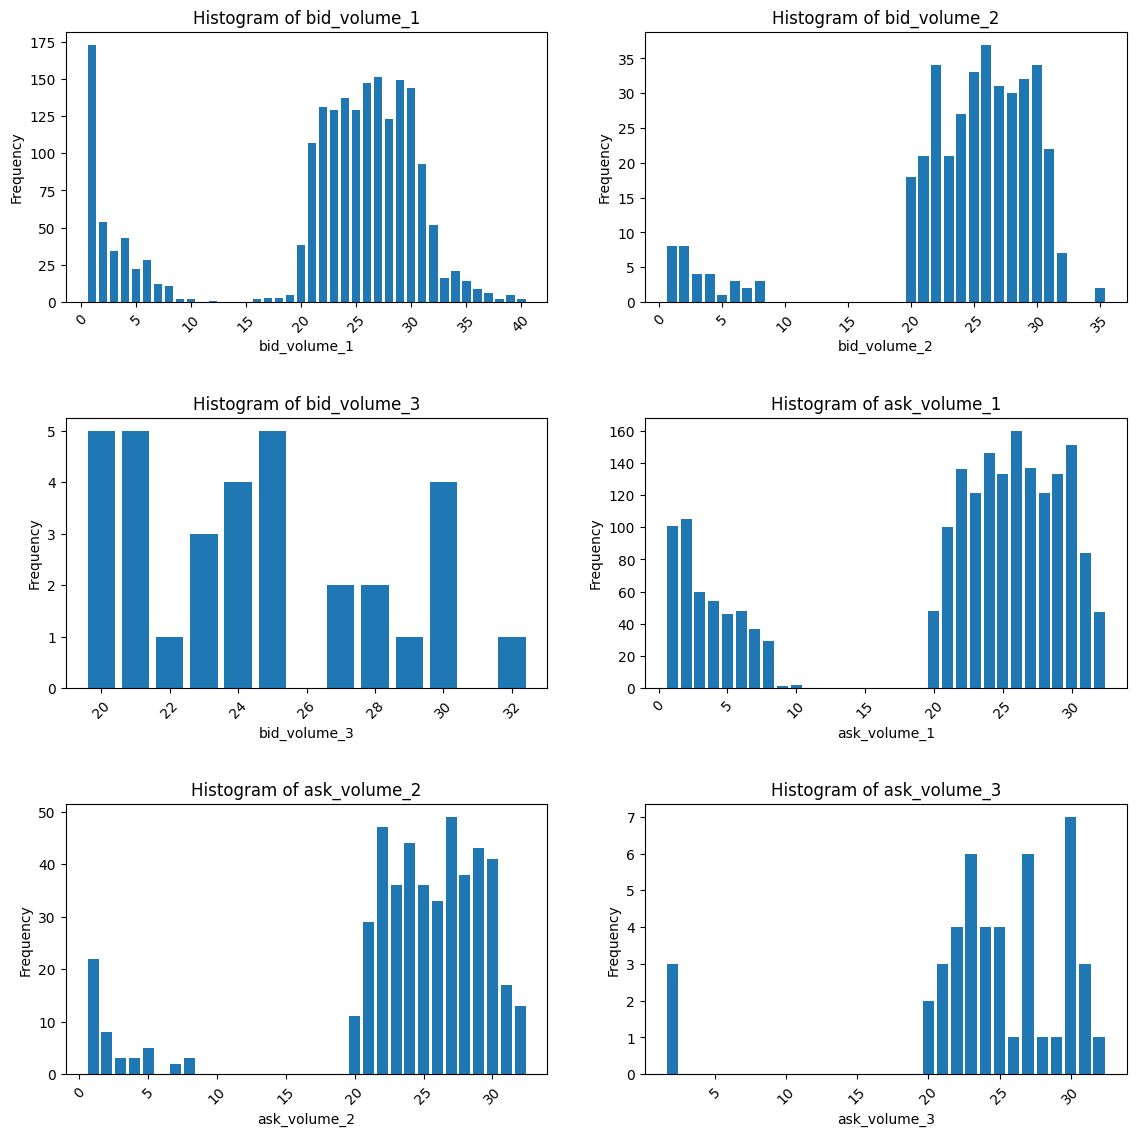

In [48]:
columns_to_plot = ['bid_volume_1', 'bid_volume_2', 'bid_volume_3',
                   'ask_volume_1', 'ask_volume_2', 'ask_volume_3']

num_plots = len(columns_to_plot)
num_rows = (num_plots + 1) // 2
num_cols = 2

plt.figure(figsize=(12, 4 * num_rows))

for i, column in enumerate(columns_to_plot, start=1):
    plt.subplot(num_rows, num_cols, i)
    
    volume_counts = kelp_data[column].value_counts()
    
    plt.bar(volume_counts.index, volume_counts.values)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column}')
    plt.xticks(rotation=45)
    plt.tight_layout(pad=3.0)

plt.show()


# Calculate MACD


Ideas

- Calculate MACD for bid/ask
- How to handle NaNs?
  - Fill with the better bid/ask for previous days and use the correct bid ask for that timestamp for bid/ask 2 and 3
- The current book in `order_depths` are the current orders outstanding that the bot can trade with

Things to do

- Check the current position of the bot and if the signal was long but he could not, then recompute the signal and go long as soon as possible
- How to choose the limit price for the order? Maybe always calculate MACDs for the worse bid/asks and determine a max fair value for the trade
- Check if some of the outstanding orders are from our bot


In [9]:
def calculate_MACD(
    data: pd.DataFrame,
    price_col: str,
    short_window: int,
    long_window: int,
    smoothing_window: int,
    min_periods: int,
):

    # Calculate the 12-period EMA

    ema_short = data[price_col].ewm(span=short_window, adjust=False).mean()

    ema_long = data[price_col].ewm(span=long_window, adjust=False).mean()

    macd = ema_short - ema_long

    signal = macd.ewm(span=smoothing_window, adjust=False).mean()

    macd.iloc[:min_periods] = np.nan

    signal.iloc[:min_periods] = np.nan

    return macd, signal, ema_short, ema_long

In [10]:
def plot_MACD(prices: pd.DataFrame, macd, signal, ema_short, ema_long):
    fig = plt.figure(figsize=(25, 10))

    gs = GridSpec(2, 1, height_ratios=[2, 1.5], figure=fig)

    price_ax = plt.subplot(gs[0])

    macd_ax = plt.subplot(gs[1])

    price_ax.plot(prices["timestamp"], prices["mid_price"])
    price_ax.plot(prices["timestamp"], ema_short, label="Short EMA", color="green")
    price_ax.plot(prices["timestamp"], ema_long, label="Long EMA", color="red")
    price_ax.legend()

    macd_ax.plot(macd, color="red", label="MACD")
    macd_ax.plot(signal, color="green", label="Signal")
    macd_ax.legend()

    plt.show()

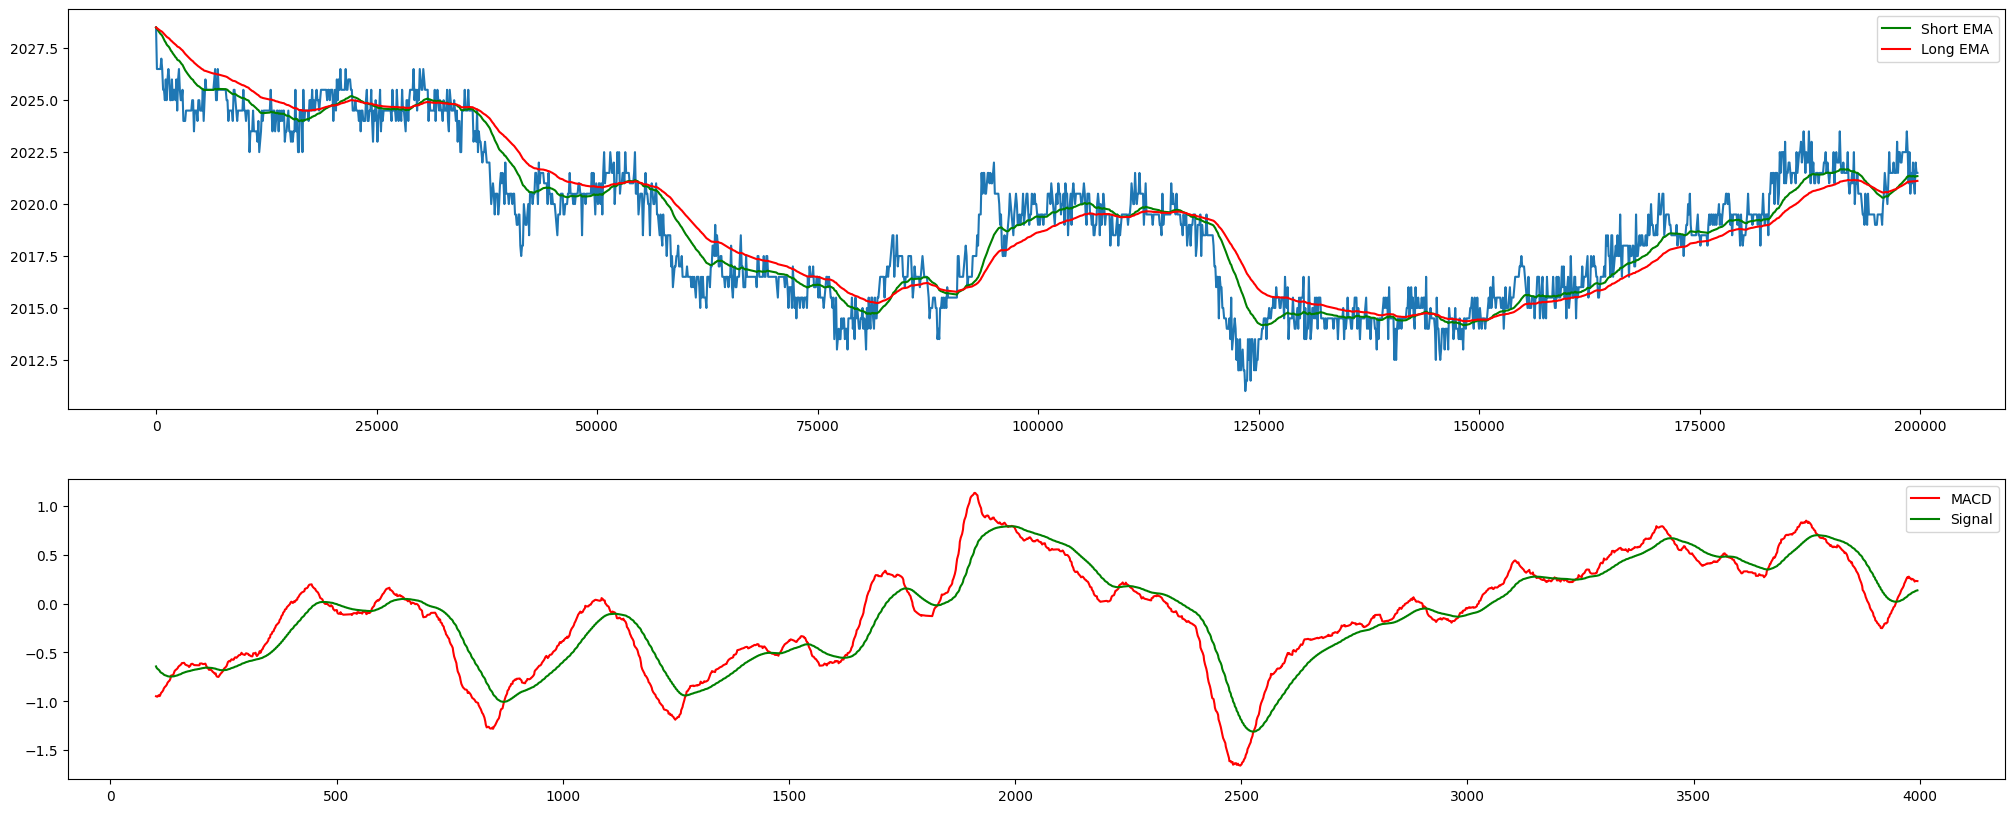

In [27]:
prices.sort_values(["product", "timestamp"], inplace=True)
kelp = prices[prices["product"] == "KELP"].sort_values("timestamp")

SHORT_WINDOW = 60
LONG_WINDOW = 120
SMOOTHING_WINDOW = 50

macd, signal, ema_short, ema_long = calculate_MACD(
    kelp, "mid_price", SHORT_WINDOW, LONG_WINDOW, SMOOTHING_WINDOW, 50
)

plot_MACD(kelp, macd, signal, ema_short, ema_long)

In [28]:
kelp["long"] = signal > macd
kelp["ret"] = kelp["mid_price"].pct_change()
kelp["long_ret"] = np.where(kelp["long"].shift(1), kelp["ret"] + 1, 1)

kelp.tail(10)

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss,long,ret,long_ret
3976,-1,198800.0,KELP,2021.0,27.0,NaN,NaN,NaN,NaN,2024.0,28.0,NaN,NaN,NaN,NaN,2022.5,140.132812,False,0.000742,1.0
3979,-1,198900.0,KELP,2020.0,35.0,NaN,NaN,NaN,NaN,2021.0,5.0,2023.0,27.0,NaN,NaN,2020.5,164.289062,False,-0.000989,1.0
3981,-1,199000.0,KELP,2020.0,25.0,NaN,NaN,NaN,NaN,2023.0,25.0,NaN,NaN,NaN,NaN,2021.5,165.179688,False,0.000495,1.0
3982,-1,199100.0,KELP,2020.0,26.0,NaN,NaN,NaN,NaN,2022.0,3.0,2023.0,27.0,NaN,NaN,2021.0,180.218750,False,-0.000247,1.0
3984,-1,199200.0,KELP,2021.0,3.0,2020.0,22.0,NaN,NaN,2023.0,22.0,NaN,NaN,NaN,NaN,2022.0,170.570312,False,0.000495,1.0
3987,-1,199300.0,KELP,2020.0,24.0,NaN,NaN,NaN,NaN,2022.0,6.0,2024.0,24.0,NaN,NaN,2021.0,153.562500,False,-0.000495,1.0
3989,-1,199400.0,KELP,2020.0,23.0,NaN,NaN,NaN,NaN,2021.0,4.0,2024.0,23.0,NaN,NaN,2020.5,153.328125,False,-0.000247,1.0
3990,-1,199500.0,KELP,2020.0,23.0,NaN,NaN,NaN,NaN,2024.0,23.0,NaN,NaN,NaN,NaN,2022.0,147.671875,False,0.000742,1.0
3992,-1,199600.0,KELP,2020.0,22.0,NaN,NaN,NaN,NaN,2023.0,1.0,2024.0,21.0,NaN,NaN,2021.5,158.132812,False,-0.000247,1.0
3995,-1,199700.0,KELP,2020.0,27.0,NaN,NaN,NaN,NaN,2023.0,2.0,2024.0,25.0,NaN,NaN,2021.5,162.531250,False,0.000000,1.0


In [29]:
entry_points = kelp["long"] != kelp["long"].shift(1)
kelp["is_entry_point"] = np.all(
    [kelp["long"] == True, kelp["long"].shift(1) == False], axis=0
)
kelp["is_exit_point"] = np.all(
    [kelp["long"] == False, kelp["long"].shift(1) == True], axis=0
)
# exit_points = kelp['long'] == True and kelp['long'] != kelp['long'].shift(1)

kelp.tail(10)

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,...,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss,long,ret,long_ret,is_entry_point,is_exit_point
3976,-1,198800.0,KELP,2021.0,27.0,NaN,NaN,NaN,NaN,2024.0,...,NaN,NaN,NaN,2022.5,140.132812,False,0.000742,1.0,False,False
3979,-1,198900.0,KELP,2020.0,35.0,NaN,NaN,NaN,NaN,2021.0,...,27.0,NaN,NaN,2020.5,164.289062,False,-0.000989,1.0,False,False
3981,-1,199000.0,KELP,2020.0,25.0,NaN,NaN,NaN,NaN,2023.0,...,NaN,NaN,NaN,2021.5,165.179688,False,0.000495,1.0,False,False
3982,-1,199100.0,KELP,2020.0,26.0,NaN,NaN,NaN,NaN,2022.0,...,27.0,NaN,NaN,2021.0,180.218750,False,-0.000247,1.0,False,False
3984,-1,199200.0,KELP,2021.0,3.0,2020.0,22.0,NaN,NaN,2023.0,...,NaN,NaN,NaN,2022.0,170.570312,False,0.000495,1.0,False,False
3987,-1,199300.0,KELP,2020.0,24.0,NaN,NaN,NaN,NaN,2022.0,...,24.0,NaN,NaN,2021.0,153.562500,False,-0.000495,1.0,False,False
3989,-1,199400.0,KELP,2020.0,23.0,NaN,NaN,NaN,NaN,2021.0,...,23.0,NaN,NaN,2020.5,153.328125,False,-0.000247,1.0,False,False
3990,-1,199500.0,KELP,2020.0,23.0,NaN,NaN,NaN,NaN,2024.0,...,NaN,NaN,NaN,2022.0,147.671875,False,0.000742,1.0,False,False
3992,-1,199600.0,KELP,2020.0,22.0,NaN,NaN,NaN,NaN,2023.0,...,21.0,NaN,NaN,2021.5,158.132812,False,-0.000247,1.0,False,False
3995,-1,199700.0,KELP,2020.0,27.0,NaN,NaN,NaN,NaN,2023.0,...,25.0,NaN,NaN,2021.5,162.531250,False,0.000000,1.0,False,False


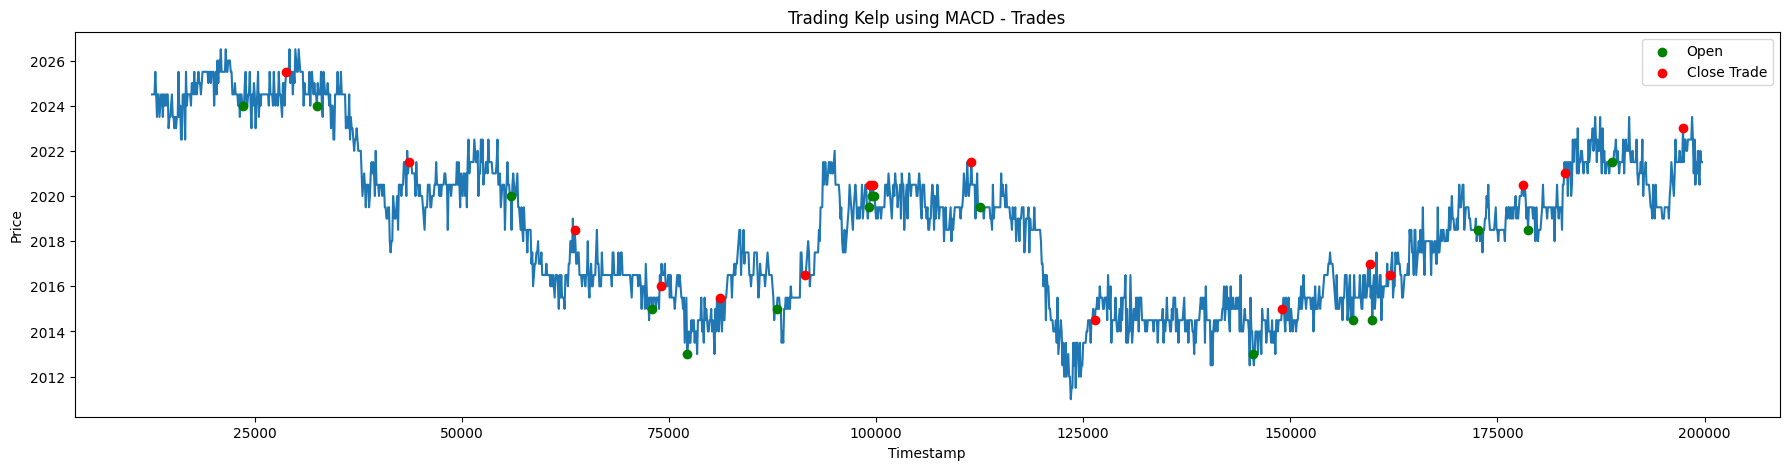

In [31]:
def plot_trades(data: pd.DataFrame, from_timestamp: int):
    fig, ax = plt.subplots(figsize=(22, 5))

    data = data[data["timestamp"] > from_timestamp].copy()

    ax.plot(data["timestamp"], data["mid_price"])

    entries = data[data["is_entry_point"]]
    exits = data[data["is_exit_point"]]

    for i, trade_series in enumerate([entries, exits]):
        color = "green" if i == 0 else "red"
        label = "Open" if i == 0 else "Close" + " Trade"
        ax.scatter(
            trade_series["timestamp"],
            trade_series["mid_price"],
            color=color,
            label=label,
            zorder=i + 2,
        )

    ax.legend()
    ax.set_title("Trading Kelp using MACD - Trades")
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Price")


plot_trades(kelp, 1.25e4)

Text(0, 0.5, 'Equity')

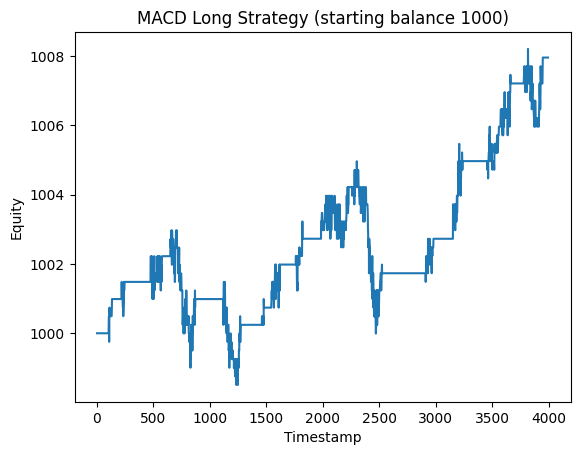

In [32]:
bal = 1000 * kelp["long_ret"].cumprod()

plt.plot(bal)
plt.title("MACD Long Strategy (starting balance 1000)")
plt.xlabel("Timestamp")
plt.ylabel("Equity")

In [33]:
(
    (kelp["ask_price_1"] - kelp["bid_price_1"]) / kelp["mid_price"]
).mean() * 100

np.float64(0.1360668929519566)

In [14]:
amethysts = prices[prices["product"] == "AMETHYSTS"].sort_values("timestamp")

(
    (amethysts["ask_price_1"] - amethysts["bid_price_1"]) / amethysts["mid_price"]
).mean() * 100

0.06776699788566183

In [34]:
kelp["long_ret"].mean() - 1

np.float64(4.0008914548028685e-06)

In [35]:
kelp["mid_price"].rolling(100).var()

1            NaN
2            NaN
5            NaN
6            NaN
9            NaN
          ...   
3987    1.299874
3989    1.301288
3990    1.301288
3992    1.301288
3995    1.303131
Name: mid_price, Length: 1998, dtype: float64

# Updating DF with the new data


In [17]:
data = [{"price": 10, "product": "SEASHELLS"}, {"price": 11, "product": "SEASHELLS"}]
df = pd.DataFrame.from_records(data)

df

,price,product
0,10,SEASHELLS
1,11,SEASHELLS


# Stoikov Model


Parameters for **Reserve Price**

$$\text{Reserve Price} = s - q\cdot \gamma \cdot\sigma^2\cdot (T-t)$$

- $q$: how distant the trader's current inventory is from the target position? $q$ indicates the difference between current and desired inventory. In our case we want to be long/short based on trend.
- $\gamma$: inventory risk the MM is willing to take
- $T-t$: time until the end of the trading session. T is usually normalized to 1, in our case t will be = timestamp / total number of ticks in a trading session.
- $\sigma$: market volatility. If the market volatility incresaes, the distance between the reservation price and market mid-price will also increase

Units:

- $\sigma$: dollars per unit time $dt$
- $\delta$ is in dollars too
- $k$ is mapping the distance to the fair price to a quantity without unit, so it is in $1/dollars$
- $\gamma$ is a risk aversion parameter. Difficult to choose, trials and errors can help.

<p align='center'>Optimal Spread</p>

$$\delta^a+\delta^b=\gamma \cdot \sigma^2(T-t) + \frac{2}{\gamma}ln(1+\frac{\gamma}{k})$$

Two of the factors are incorporated from the reservation price formula ($\gamma $ and $(T-t)$) and a new factor is incorporated:

- $k$ - Order book Liquidity/Density: look at ways to calculate it. If k is significant, we are assuming the order book is denser and we need to have more competitive spreads. If the order book is less competitive we can have wider spreads

**Combining the Two**

$$\text{Ask/Bid} = \text{Res Price} \pm \frac{\text{Optimal Spread}}{2}$$

### Estimating k

$k$ parameter models order book liquidity, with larger values corresponding to higher trading intensity. For a given time interval $\pi_n=t_n-t_{n-1}$, $k$ can be estimated as

$$k_n^a=\frac{\lambda_n^a\cdot\lambda^a_{n-1}}{\lambda_n^a-\lambda^a_{n-1}}$$

Where lambdas are the orderbook update arrival rates on the ask and bid sides, in the time interval $\pi_n$. "Note that this approach allows us to estimate the k parameters simply by coutning the orders arrivals at each time interval $\pi_n$" => **estimate $\lambda_n^a$ as number of bid/asks in time $n$?**


In [18]:
orders_t = 8
orders_t_1 = 10

(orders_t * orders_t_1) / (orders_t - orders_t_1)

-40.0

In [36]:
def stoikov_model_res_price(s, q, gamma, sigma, T, t):
    return s - q * gamma * sigma**2 * (T - t)


def stoikov_model_spread(gamma, sigma, T, t, k):
    return gamma * sigma**2 * (T - t) + 2 / gamma * np.log(1 + gamma / k)

In [20]:
# testing
GAMMA = 0.01
K = 0.5

SIGMA = np.sqrt(3.8)
T = 1
t = 0
S = 5039.5  # current midprice

CURRENT_POS = -20
TARGET_POS = 20
Q = CURRENT_POS - TARGET_POS

r = stoikov_model_res_price(S, Q, GAMMA, SIGMA, T, t)
spread_sum = stoikov_model_spread(GAMMA, SIGMA, T, t, K)

print(r)  # 98 makes sense since we want to
print(spread_sum)


def get_bid_ask(res_price, spread):
    return res_price - spread / 2, res_price + spread / 2


bid, ask = get_bid_ask(r, spread_sum)
print(f"\ncurrent midprice is {S}, refprice is {r}")
print(f"bid: {bid:.2f}, ask: {ask:.2f}, spread: {ask - bid:.2f}")

5041.02
3.9985254592359456

current midprice is 5039.5, refprice is 5041.02
bid: 5039.02, ask: 5043.02, spread: 4.00


## Fixing Imbalance


In [21]:
matrix = np.array([[1, 2, 3], [1, np.nan, 3], [np.nan, 1, 2]])
matrix

array([[ 1.,  2.,  3.],
       [ 1., nan,  3.],
       [nan,  1.,  2.]])

In [22]:
bid1 = np.array([1, np.nan, np.nan])
volb1 = np.array([1, np.nan, np.nan])
ask1 = np.array([1, 2, 3])
vola1 = np.array([1, 2, 3])

np.vstack([bid1, vola1, ask1, volb1]).T

array([[ 1.,  1.,  1.,  1.],
       [nan,  2.,  2., nan],
       [nan,  3.,  3., nan]])

In [23]:
np.any(np.isnan(matrix), axis=1).reshape(-1, 1)

array([[False],
       [ True],
       [ True]])

In [24]:
prices.iloc[50]


def vw_mid_price(data):
    # S = Pa * Vb / (Va + Vb) + Pb * Va / (Va + Vb)
    bid_amt = data["bid_size_1"] + data["bid_size_2"] + data["bid_size_3"]
    ask_amt = data["ask_size_1"] + data["ask_size_2"] + data["ask_size_3"]
    tot_amt = bid_amt + ask_amt

    pa1 = data["ask_price_1"]
    pa2 = data["ask_price_2"]
    pa3 = data["ask_price_3"]
    pb1 = data["bid_price_1"]
    pb2 = data["bid_price_2"]
    pb3 = data["bid_price_3"]
    sa1 = data["ask_size_1"]
    sa2 = data["ask_size_2"]
    sa3 = data["ask_size_3"]
    sb1 = data["bid_size_1"]
    sb2 = data["bid_size_2"]
    sb3 = data["bid_size_3"]

    m1 = (pa1 * sb1) / (sa1 + sb1) + (pb1 * sa1) / (sa1 + sb1)
    m2 = (pa2 * sb2) / (sa2 + sb2) + (pb2 * sa2) / (sa2 + sb2)
    m3 = (pa3 * sb3) / (sa3 + sb3) + (pb3 * sa3) / (sa3 + sb3)
    print(f"m1: {m1}, m2: {m2}, m3: {m3}")
    mids = np.array([m1, m2, m3])
    mids[np.isnan(mids)] = 0
    vols = np.array([sa1 + sb1, sa2 + sb2, sa3 + sb3])
    return sum(mids * vols / sum(vols))
    return sum([m1, m2, m3]) / 3

    # S = ( Pa1 * Vb1 + Pa2 * Vb2 ... ) / total volum
    s = (pa1 * sb1 + pa2 * sb2 + pa3 * sb3) / tot_amt + (
        pb1 * sa1 + pb2 * sa2 + pb3 * sa3
    ) / tot_amt
    return s


def vw_mid_price_vectorized(data):
    bid_sizes = np.abs(np.array([data[f"bid_volume_{i+1}"] for i in range(3)]))
    ask_sizes = np.abs(np.array([data[f"ask_volume_{i+1}"] for i in range(3)]))
    bid_prices = np.abs(np.array([data[f"bid_price_{i+1}"] for i in range(3)]))
    ask_prices = np.abs(np.array([data[f"ask_price_{i+1}"] for i in range(3)]))

    stacked = np.vstack([bid_sizes, ask_sizes, bid_prices, ask_prices]).T
    mask = ~np.any(np.isnan(stacked), axis=1)

    print(mask)

    mids = (ask_prices[mask] * bid_sizes[mask]) / (
        ask_sizes[mask] + bid_sizes[mask]
    ) + (bid_prices[mask] * ask_sizes[mask]) / (ask_sizes[mask] + bid_sizes[mask])
    # mids = np.nan_to_num(mids)
    vols = ask_sizes[mask] + bid_sizes[mask]

    print(f"vols: \n{ask_sizes[mask]}, \n{bid_sizes[mask]}")
    print(f"data: \n{stacked}")

    print(mids, vols)

    s = np.sum(mids * vols) / np.sum(vols)

    return s

In [25]:
data = {
    "timestamp": 0,
    "ask_volume_1": 22,
    "ask_volume_2": np.nan,
    "ask_volume_3": np.nan,
    "bid_volume_1": 7,
    "bid_volume_2": 22,
    "bid_volume_3": np.nan,
    "ask_price_1": 5042,
    "ask_price_2": np.nan,
    "ask_price_3": np.nan,
    "bid_price_1": 5036,
    "bid_price_2": 5035,
    "bid_price_3": np.nan,
    "mid_price": 5039.5,
    "spread": 0.0013890266891556703,
}

mid = vw_mid_price_vectorized(data)
mid

[ True False False]
vols: 
[22.], 
[7.]
data: 
[[   7.   22. 5036. 5042.]
 [  22.   nan 5035.   nan]
 [  nan   nan   nan   nan]]
[5037.44827586] [29.]


5037.448275862069

In [26]:
def old_mid_price_adj(data):
    data = {i: data[i] if not np.isnan(data[i]) else 0 for i in data}

    bid_amt = data["bid_volume_1"] + data["bid_volume_2"] + data["bid_volume_3"]
    ask_amt = data["ask_volume_1"] + data["ask_volume_2"] + data["ask_volume_3"]
    tot_amt = (
        data["bid_volume_1"]
        + data["bid_volume_2"]
        + data["bid_volume_3"]
        + data["ask_volume_1"]
        + data["ask_volume_2"]
        + data["ask_volume_3"]
    )

    vw_bid = (
        data["bid_price_1"] * data["bid_volume_1"]
        + data["bid_price_2"] * data["bid_volume_2"]
        + data["bid_price_3"] * data["bid_volume_3"]
    ) / bid_amt
    vw_ask = (
        data["ask_price_1"] * data["ask_volume_1"]
        + data["ask_price_2"] * data["ask_volume_2"]
        + data["ask_price_3"] * data["ask_volume_3"]
    ) / ask_amt

    s = vw_ask * bid_amt / tot_amt + vw_bid * ask_amt / tot_amt

    print(f"vw_bid: {vw_bid}, vw_ask: {vw_ask}")

    return s


mid_old = old_mid_price_adj(data)
mid_old

vw_bid: 5035.241379310345, vw_ask: 5042.0


5039.084516565246

In [39]:
import seaborn as sns


def plot_orderbook(data, mid, mid_old):
    # your original data
    ask_price = [
        data[f"ask_price_{i}"] if not np.isnan(data["ask_price_1"]) else 0
        for i in range(1, 4)
    ]
    ask_qty = [
        data[f"ask_volume_{i}"] if not np.isnan(data["ask_volume_1"]) else 0
        for i in range(1, 4)
    ]
    bid_price = [
        data[f"bid_price_{i}"] if not np.isnan(data["bid_price_1"]) else 0
        for i in range(1, 4)
    ]
    bid_qty = [
        data[f"bid_volume_{i}"] if not np.isnan(data["bid_volume_1"]) else 0
        for i in range(1, 4)
    ]

    ask_df = pd.DataFrame({"price": ask_price, "quantity": ask_qty})
    bid_df = pd.DataFrame({"price": bid_price, "quantity": bid_qty})

    fig, ax = plt.subplots()
    ax.set_title(f"Order Book Depth Chart")
    sns.ecdfplot(
        x="price", weights="quantity", stat="count", data=ask_df, ax=ax, color="red"
    )
    sns.ecdfplot(
        x="price",
        weights="quantity",
        stat="count",
        complementary=True,
        data=bid_df,
        ax=ax,
        color="green",
    )
    # complementary=True allows reflects that lower bids are "better"
    ax.set_xlabel("Price")
    ax.set_ylabel("Quantity")

    ax.vlines(mid, 0, 30, color="blue", label="Mid Price")
    ax.vlines(mid_old, 0, 30, color="black", label="Mid Price (old)")

    ax.legend()

In [40]:
plot_orderbook(data, mid, mid_old)

NameError: name 'data' is not defined

# Amethysts


In [41]:
resin = prices[prices["product"] == "RAINFOREST_RESIN"].sort_values("timestamp")

resin.head()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,-1,0.0,RAINFOREST_RESIN,10002.0,1.0,9996.0,2.0,9995.0,29.0,10004.0,2.0,10005.0,29.0,NaN,NaN,10003.0,0.0
3,-1,100.0,RAINFOREST_RESIN,9996.0,2.0,9995.0,22.0,NaN,NaN,10004.0,2.0,10005.0,22.0,NaN,NaN,10000.0,2.0
4,-1,200.0,RAINFOREST_RESIN,9995.0,20.0,NaN,NaN,NaN,NaN,10005.0,20.0,NaN,NaN,NaN,NaN,10000.0,-6.0
7,-1,300.0,RAINFOREST_RESIN,9996.0,2.0,9995.0,29.0,NaN,NaN,10004.0,2.0,10005.0,29.0,NaN,NaN,10000.0,-106.0
8,-1,400.0,RAINFOREST_RESIN,9996.0,2.0,9995.0,25.0,NaN,NaN,10004.0,2.0,10005.0,25.0,NaN,NaN,10000.0,-114.0


In [42]:
resin["mid_price"].rolling(50).var().mean()

np.float64(2.1896800698661543)

In [53]:
# testing
GAMMA = 0.025
K = 0.25

SIGMA = np.sqrt(2.24)
T = 1
t = 0
S = 10_000  # current midprice

CURRENT_POS = -20
TARGET_POS = 0
Q = CURRENT_POS - TARGET_POS

r = stoikov_model_res_price(S, Q, GAMMA, SIGMA, T, t)
spread_sum = stoikov_model_spread(GAMMA, SIGMA, T, t, K)

print(r)  # 98 makes sense since we want to
print(spread_sum)


def get_bid_ask(res_price, spread):
    return res_price - spread / 2, res_price + spread / 2


bid, ask = get_bid_ask(r, spread_sum)
print(f"\ncurrent midprice is {S}, refprice is {r}")
print(f"bid: {bid:.2f}, ask: {ask:.2f}, spread: {ask - bid:.2f}")

10001.12
7.680814384345995

current midprice is 10000, refprice is 10001.12
bid: 9997.28, ask: 10004.96, spread: 7.68
